In [1]:
!nvidia-smi

Fri Aug 25 00:53:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:06:00.0 Off |                    0 |
| N/A   34C    P0    43W / 300W |      3MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:07:00.0 Off |                    0 |
| N/A   

In [2]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU device:',torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('No GPU avaialable, Using CPU')

torch.cuda.set_device(0)

/home/sur06423/miniconda3/envs/vi_trans/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU device: Tesla V100-SXM2-32GB


In [3]:
import sys
sys.path.append('/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline')

In [4]:
image_path = "/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/daa_dataset/"
train_dir = "/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/daa_dataset/train"
test_dir = "/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/daa_dataset/test"
val_dir = "/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/daa_dataset/val"

# Create Datasets & Dataloader

In [5]:
from src.components import data_setup
from torchvision import transforms

# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224
BATCH_SIZE = 16
# Create vit transform pipeline manually
vit_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
]) 

train_dataloader, test_dataloader , val_dataloader, class_names = data_setup.create_dataloaders(
    train_dir= train_dir,
    test_dir=test_dir,
    val_dir = val_dir,
    transform=vit_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, val_dataloader, class_names

/home/sur06423/miniconda3/envs/vi_trans/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/sur06423/miniconda3/envs/vi_trans/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


(<torch.utils.data.dataloader.DataLoader at 0x7f0dd5e142b0>,
 ['closing_bottle',
  'closing_door_inside',
  'closing_door_outside',
  'closing_laptop',
  'drinking',
  'eating',
  'entering_car',
  'exiting_car',
  'fastening_seat_belt',
  'fetching_an_object',
  'interacting_with_phone',
  'looking_or_moving_around (e.g. searching)',
  'opening_backpack',
  'opening_bottle',
  'opening_door_inside',
  'opening_door_outside',
  'opening_laptop',
  'placing_an_object',
  'preparing_food',
  'pressing_automation_button',
  'putting_laptop_into_backpack',
  'putting_on_jacket',
  'putting_on_sunglasses',
  'reading_magazine',
  'reading_newspaper',
  'sitting_still',
  'taking_laptop_from_backpack',
  'taking_off_jacket',
  'taking_off_sunglasses',
  'talking_on_phone',
  'unfastening_seat_belt',
  'using_multimedia_display',
  'working_on_laptop',
  'writing'])

# Number of (Train Batches, Test Batches, Validation Batches) : (16242, 5458, 3502), Batch_SIZE = 16

In [6]:
len(train_dataloader), len(test_dataloader), len(val_dataloader)

(16242, 5458, 3502)

#  Visualize a single image

In [7]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(10))

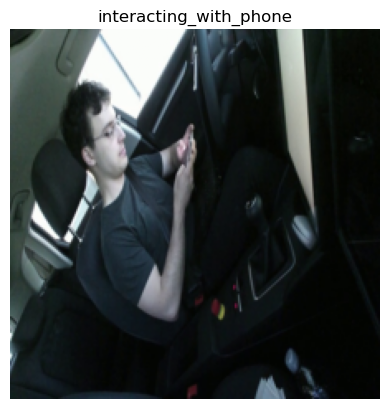

In [8]:
import matplotlib.pyplot as plt
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [18]:
image_1 = image.unsqueeze(0)
image_1.shape

torch.Size([1, 3, 224, 224])

In [27]:
import os
import zipfile
from pathlib import Path
import requests

data_path = Path("/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/")
destination = "Images"
image_path = data_path / destination
source = "https://wiki.tum.de/download/attachments/1144685188/figure_8.png"
# Download image
target_file = Path(source).name
with open(image_path / target_file, "wb") as f:
    request = requests.get(source)
    print(f"[INFO] Downloading {target_file} from {source}...")
    f.write(request.content)


[INFO] Downloading figure_8.png from https://wiki.tum.de/download/attachments/1144685188/figure_8.png...


# The ViT architecture is comprised of several stages:

![ViT architecture](/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/Images/figure_8.png)

* **Patch + Position Embedding (inputs)** - Turns the input image into a sequence of image patches \
and add a position number what order the patch comes in.

* **Linear projection of flattened patches (Embedded Patches)** - The image patches get turned into an embedding, \
the benefit of using an embedding rather than just the image values is that an embedding is a learnable representation \
typically in the form of a vector of the image that can improve with training.

* **Norm** - This is short for "Layer Normalization" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, \
you can use LayerNorm via the PyTorch layer torch.nn.LayerNorm().

* **Multi-Head Attention** - This is a Multi-Headed Self-Attention layer or "MSA" for short. \
You can create an MSA layer via the PyTorch layer torch.nn.MultiheadAttention().

* **MLP (or Multilayer perceptron)** - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case,\
 a collection of layers with a forward() method). In the ViT Paper, the authors refer to the MLP as "MLP block" \
 and it contains two torch.nn.Linear() layers with a torch.nn.GELU() non-linearity activation \
 in between them and a torch.nn.Dropout() layer after each (Appendex B.1).

* **Transformer Encoder** - The Transformer Encoder, is a collection of the layers listed above. \
There are two skip connections inside the Transformer encoder (the "+" symbols) meaning \
the layer's inputs are fed directly to immediate layers as well as subsequent layers. \
The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.

* **MLP Head** - This is the output layer of the architecture, it converts the learned features of an input to a class output. \
Since we're working on image classification, you could also call this the "classifier head". \
The structure of the MLP Head is similar to the MLP block.

In [9]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

from torchinfo import summary

1.13.1
0.15.2a0


In [9]:
import torch
from torch import nn

# First Class: PatchEmbedding class
# 1. Creating a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768. For Large D= 1024, For Vit-Huge D = 1280.
    """ 
    # 2. Initialized the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patch_size = patch_size
        
        # 3. Created a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Created a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Defined the forward method 
    def forward(self, x):
        # Created assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        
        # Performed the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]


# Second Class: MultiheadSelfAttentionBlock class
# 1. Creating a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialized the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()
        
        # 3. Created the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Created the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?
        
    # 5. Created a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output


# Third Class: MLPBlock class
# 1. Created a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialized the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()
        
        # 3. Created the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )
    
    # 5. Created a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

# Fourth Class: TransformerEncoderBlock class
# 1. Created a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialized the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Created MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # 4. Created MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
    # 5. Created a forward() method  
    def forward(self, x):
        
        # 6. Created residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x 
        
        # 7. Created residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x 
        
        return x

'''
# Created the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?
'''

# Fifth Class: Vision Transformer Model ViT class
# 1. Created a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialized the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=34): # Default for ImageNet=100 but for daa RGB dataset= 34
        super().__init__() # don't forget the super().__init__()!
        
        # 3. Make the image size is divisble by the patch size 
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        # 4. Calculated number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        # 5. Created learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # 6. Created learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # 7. Created embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Created patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 9. Created Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout, attn_dropout=attn_dropout) for _ in range(num_transformer_layers)])
       
        # 10. Created classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    # 11. Created a forward() method
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Created class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension

        # 14. Created patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concatenated class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Added position embedding to patch embedding (equation 1) 
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Passed patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [10]:
# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=34)

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[ 0.6012, -0.1516,  0.1407,  0.7479,  0.7452, -0.6477,  0.0731, -0.5244,
         -0.3073,  0.6969,  0.6550, -0.4123, -0.0558, -1.0320,  0.6457,  0.6473,
         -0.3359,  1.0253,  0.4199,  0.8746,  0.0341,  0.1867,  0.0800, -0.5060,
         -0.2541,  0.1652,  0.0582, -0.0845, -0.4469,  0.6364, -0.1509,  0.6132,
         -0.0247,  1.2324]], grad_fn=<AddmmBackward0>)

In [11]:
# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit, 
         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
         #col_names=["input_size"], # uncomment for smaller output
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 34]             152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

In [12]:
import torch
from torch import nn

class CustomViT(nn.Module):
    def __init__(self,
                 img_size=224,
                 in_channels=3,
                 patch_size=16,
                 num_transformer_layers=12,
                 embedding_dim=768,
                 mlp_size=3072,
                 num_heads=12,
                 attn_dropout=0,
                 mlp_dropout=0.1,
                 embedding_dropout=0.1,
                 num_classes=34):
        super().__init__()

        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        self.num_patches = (img_size * img_size) // patch_size**2

        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim), requires_grad=True)
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        self.conv_proj = nn.Sequential(nn.Conv2d(in_channels=in_channels,
                                                 out_channels=embedding_dim,
                                                 kernel_size=patch_size,
                                                 stride=patch_size,
                                                 padding=0),
                                                 nn.Flatten(start_dim=2, end_dim=3))
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                        nhead=num_heads,
                                                        dim_feedforward=mlp_size,
                                                        dropout=mlp_dropout,
                                                        activation="gelu",
                                                        batch_first=True,
                                                        norm_first=True)
        
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=self.encoder_layer, num_layers = num_transformer_layers)
        self.layernorm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.classifier = nn.Sequential(nn.Linear(in_features=embedding_dim, out_features=num_classes))
    
    def forward(self, x):
        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size, -1, -1)
        x_patched = self.conv_proj(x)
        x_patch_permuted = x_patched.permute(0, 2, 1)
        x = torch.cat((class_token, x_patch_permuted), dim=1)
        x = self.position_embedding + x
        x = self.embedding_dropout(x)
        x = self.transformer_encoder(x)
        x = self.layernorm(x)
        x = self.classifier(x[:, 0])
        return x


In [13]:
# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit_custom = CustomViT(num_classes=34)

# Pass the random image tensor to our ViT instance
vit_custom(random_image_tensor)

tensor([[ 0.7560,  1.2750,  0.5744, -0.4658, -0.6555,  0.2125,  0.3939, -0.8233,
          0.2664, -0.4641, -0.3603,  0.4279,  0.0310, -0.3995,  0.0583,  1.1891,
         -0.2355, -1.0266,  0.0609,  0.4838,  0.0551,  0.5877, -0.8100, -0.3879,
         -0.0992, -0.2780,  0.5893,  0.2279, -0.3036,  1.2489, -1.3796, -0.3363,
          0.1615,  0.9847]], grad_fn=<AddmmBackward0>)

In [14]:
# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit_custom, 
         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
         #col_names=["input_size"], # uncomment for smaller output
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
CustomViT (CustomViT)                              [32, 3, 224, 224]    [32, 34]             7,239,936            True
├─Sequential (conv_proj)                           [32, 3, 224, 224]    [32, 768, 196]       --                   True
│    └─Conv2d (0)                                  [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (1)                                 [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                      [32, 197, 768]       [32, 197, 768]       --                   --
├─TransformerEncoder (transformer_encoder)         [32, 197, 768]       [32, 197, 768]       --                   True
│    └─ModuleList (layers)                         --                   --                   --                   True
│    │    └─TransformerEncoderLayer (0)        

In [10]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # DEFAULT means the best available weights
# pretrained_vit = vit(weights = pretrained_vit_weights).to(device)

In [11]:
pretrained_vit = torchvision.models.vit_b_16(weights = pretrained_vit_weights).to(device)

In [12]:
pretrained_vit.state_dict()

OrderedDict([('class_token',
              tensor([[[-1.1816e-03,  2.7023e-03,  2.5492e-03, -1.0183e-03, -6.8836e-04,
                        -7.0989e-03, -1.0262e-03, -5.0719e-04, -3.4578e-04,  7.2080e-04,
                        -1.2402e-03,  7.5692e-03, -7.7170e-04, -4.8869e-04, -3.9637e-03,
                        -1.4612e-03, -1.1996e-03, -6.3172e-04, -1.0178e-03, -6.6078e-04,
                        -1.0705e-03, -6.4979e-03, -7.7540e-04, -6.0426e-04, -7.3446e-04,
                        -3.1418e-03, -7.1227e-03, -1.0940e-03, -2.3099e-03, -7.0811e-04,
                        -8.9314e-04, -5.3678e-04,  7.4808e-03, -3.7627e-04, -1.5883e-03,
                        -7.2012e-04, -2.4297e-04, -6.3393e-04, -7.0300e-04, -6.7053e-04,
                         4.7179e-03, -7.9351e-04,  2.6560e-03, -1.0116e-03,  2.9899e-03,
                        -8.4867e-04, -5.3730e-03, -5.1106e-04,  5.5209e-03, -7.5487e-04,
                        -4.7614e-04, -2.3371e-03, -1.0001e-02, -5.9229e-04,  3.36

In [15]:
import torch.nn as nn
# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# Change the classifier head
pretrained_vit.heads = nn.Linear(in_features=768, out_features=34)

In [17]:
# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
         input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
         #col_names=["input_size"], # uncomment for smaller output
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 34]              768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1